### AutoML test 02: using Optuna library on my GraphAutoencoder model with 2 LAYERS

Output: 

 - For dynamic: **node_embeddings_D_AutoML-2relu**
 
 - For static: **node_embeddings_S_AutoML-2relu.csv**

In [ ]:
# !pip install fastdtw
# !pip install plotly

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import optuna
import pandas as pd
import numpy as np
import torch.nn as nn
import os

from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv

# Model Fusion Approach

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

# ====== CONFIGURATION ======
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# ========== Encoder ==========
class GSAGEVectorAttnEncoder(nn.Module): 
    def __init__(self, dynamic_dim, static_dim, hidden_dim, latent_dim, activation="relu", dropout_static=0.6): 
        super().__init__()
        self.dynamic_dim = dynamic_dim
        self.static_dim = static_dim
        self.input_dim = dynamic_dim + static_dim
        self.dropout_static = dropout_static

        # Vector-level attention gate (sigmoid gating)
        self.attn_gate = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim),
            nn.Sigmoid()
        )

        self.conv1 = SAGEConv(self.input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, latent_dim)
        self.activation = self._get_activation(activation)

    def _get_activation(self, name):
        return {
            "relu": F.relu,
            "leaky_relu": lambda x: F.leaky_relu(x, 0.01),
            "tanh": torch.tanh,
            "selu": F.selu,
            "gelu": F.gelu,
            "swish": lambda x: x * torch.sigmoid(x),
            "none": lambda x: x
        }.get(name.lower(), F.relu)

    def forward(self, x, edge_index, return_attention=False):
        x_dyn = x[:, :self.dynamic_dim]
        x_stat = x[:, self.dynamic_dim:]

        # Apply dropout to static (optional)
#         if self.training and self.dropout_static > 0:
        x_stat = F.dropout(x_stat, p=self.dropout_static)

        # Vector-level attention gate
        x_cat = torch.cat([x_dyn, x_stat], dim=1)
        gate = self.attn_gate(x_cat)  # shape [N, input_dim]

        # Split gate for dynamic/static
        g_dyn = gate[:, :self.dynamic_dim]
        g_stat = gate[:, self.dynamic_dim:]

        # Apply attention
        x_attn = torch.cat([g_dyn * x_dyn, g_stat * x_stat], dim=1)

        # GCN Layers
        x = self.activation(self.conv1(x_attn, edge_index))
        x = self.conv2(x, edge_index)

        if return_attention:
            return x, g_dyn, g_stat
        return x


# ========== Decoder ==========
class GSAGEDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, activation="relu"):
        super().__init__()
        self.deconv1 = SAGEConv(latent_dim, hidden_dim)
        self.deconv2 = SAGEConv(hidden_dim, output_dim)
        self.activation = self._get_activation(activation)

    def _get_activation(self, name):
        return {
            "relu": F.relu,
            "leaky_relu": lambda x: F.leaky_relu(x, 0.01),
            "tanh": torch.tanh,
            "selu": F.selu,
            "gelu": F.gelu,
            "swish": lambda x: x * torch.sigmoid(x),
            "none": lambda x: x
        }.get(name.lower(), F.relu)

    def forward(self, x, edge_index):
        x = self.activation(self.deconv1(x, edge_index))
        x = self.deconv2(x, edge_index)
        return x


# ========== Full Model ==========
class GraphAutoencoderVectorAttn(nn.Module): 
    def __init__(self, dynamic_dim, static_dim, hidden_dim, latent_dim, activation="relu", dropout_static=0.7):
        super().__init__()
        self.dynamic_dim = dynamic_dim
        self.static_dim = static_dim
        self.total_dim = dynamic_dim + static_dim

        self.encoder = GSAGEVectorAttnEncoder(dynamic_dim, static_dim, hidden_dim, latent_dim, activation, dropout_static)
        self.decoder = GSAGEDecoder(latent_dim, hidden_dim, self.total_dim, activation)

    def forward(self, x, edge_index, return_attention=False):
#         if return_attention:
        encoded, g_dyn, g_stat = self.encoder(x, edge_index, return_attention=True)
        decoded = self.decoder(encoded, edge_index)
        return decoded, encoded, g_dyn, g_stat
#         else:
#             encoded = self.encoder(x, edge_index)
#             decoded = self.decoder(encoded, edge_index)
#             return decoded, encoded


Using device: cuda


# Parameters

In [6]:
# Optimizer
loss_func = "MSE"  # "MSE" (Mean Square Error)   # "MAE" (Mean Absolute Error) #Huber
data_set = "real" # "real"  "artificial"
    
    
type_graph_conv = "SAGE"# "SAGE" (WORKS VERY GOOD FOR ARTIFICIAL) # GAT   


# Intervals of parameters for Dynamic data (input dim=144)
HIDDEN_DIM_RANGE = (144, 256)
LATENT_DIM_RANGE = (64, 128)
LR_RANGE = (1e-4, 1e-1)
WEIGHT_DECAY = (1e-6, 1e-3)
NUM_EPOCHS_RANGE = (200, 1000) #(5000, 5200)  
N_LAYERS = 2
ACTIVATION_OPTION = "relu"
TYPE_DATA = 'V2'  

In [8]:
suffix = '26_june_exp_smooth_attention_drop_0.7'  # 0.06 file has better result #0.4 was wrong

output_folder = f'{data_set}/{type_graph_conv}_{suffix}'
os.makedirs(output_folder, exist_ok=True)

# Reading original data

In [9]:
output_folder

'real/SAGE_26_june_exp_smooth_attention_drop_0.7'

In [10]:

if(data_set =="artificial"):
    print("artificial data")
    name_file_dataset = os.path.join("../datasets", "artificial_data_12_clusters_full.csv")
else: # real dataset
    print("real data")
    name_file_dataset = "../datasets/datasubset_nodes_waqar.csv"

df_nodes = pd.read_csv(name_file_dataset) # orignal raw data
df_nodes

real data


,Nodo,2006.01,2006.02,2006.03,2006.04,2006.05,2006.06,2006.07,2006.08,2006.09,...,menores_de_18_anos_taxa,18_a_65_anos_taxa,maiores_de_65_anos_taxa,Pontos_de_onibus,Estacao_de_metro,Estacao_de_trem,Terminal_de_onibus,Favela_proxima,lat,long
0,573641,1,0,0,0,0,0,0,0,0,...,0.210939,0.631893,0.157168,0.0,1.0,3.0,1.0,0.0,-23.562991,-46.703965
1,573643,0,0,0,0,0,0,1,0,1,...,0.169365,0.648065,0.182571,0.0,3.0,3.0,1.0,0.0,-23.567465,-46.702229
2,573644,0,1,0,1,1,0,0,0,0,...,0.125065,0.742215,0.132719,0.0,3.0,3.0,1.0,0.0,-23.572962,-46.699235
3,582438,0,0,0,1,0,0,0,2,0,...,0.125109,0.723529,0.151361,0.0,2.0,2.0,3.0,0.0,-23.528187,-46.661920
4,582442,0,0,0,0,0,0,0,0,0,...,0.147651,0.691275,0.161074,0.0,0.0,2.0,4.0,0.0,-23.517308,-46.656944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,25798409,0,0,0,0,0,0,0,0,0,...,0.266357,0.652312,0.081330,0.0,0.0,4.0,2.0,1.0,-23.507885,-46.712039
14636,25870742,0,0,0,0,0,0,0,0,0,...,0.231285,0.676118,0.092597,0.0,0.0,1.0,2.0,0.0,-23.563471,-46.611300
14637,25871831,0,0,0,0,0,0,0,0,0,...,0.220503,0.686654,0.092843,0.0,3.0,4.0,5.0,0.0,-23.551894,-46.625727
14638,25875949,0,0,0,0,0,0,0,0,0,...,0.229763,0.672624,0.097612,0.0,1.0,3.0,5.0,1.0,-23.521011,-46.637123


#### Dataset management
✅ [Checked] Check 'Pontos_de_onibus' column, it looks like a column of zeros

### Slicing dyanmic data

In [11]:
dynamic_dt_orig = df_nodes.iloc[:, 1:145] 
dynamic_dt = dynamic_dt_orig

# Exponential Smoothing

In [ ]:
# from statsmodels.tsa.api import SimpleExpSmoothing


log_df = np.log1p(dynamic_dt)
dynamic_smooth = log_df.apply(lambda row: row.ewm(alpha=0.1).mean(), axis=1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

number=50
np.random.seed(42)
idx_random = np.random.choice(dynamic_smooth.index, size=number, replace=False)


dates= pd.to_datetime(dynamic_smooth.columns.str.replace(".", "-", regex=False) + "-01")

plt.figure(figsize=(14, 6))
for idx in idx_random:
    plt.plot(dates, dynamic_smooth.loc[idx], alpha=0.3)

plt.xlabel("Date")
plt.ylabel("# crimes")
plt.title(f"{number} temporal series selected randomly")
plt.tight_layout()
plt.show() 

In [ ]:
dynamic_smooth

In [ ]:
pd.Series(dynamic_smooth.values.flatten()).plot.box()

In [ ]:
import matplotlib.pyplot as plt

plt.hist(np.array(dynamic_smooth)[np.array(dynamic_smooth) > 0].ravel(), bins=100)
plt.title("Histogram of non-zero normalized values")
plt.show()

## Slice the Static data

In [16]:
static_dt = df_nodes.iloc[:, 145:-2]  # Slicing static data
static_dt = static_dt.drop(columns=["Pontos_de_onibus"])

In [17]:
static_dt

,Renda_media_por_domicilio,Renda_media_responsaveis,Responsaveis_sem_renda_taxa,Alfabetizados_de_7_a_15_anos,menores_de_18_anos_taxa,18_a_65_anos_taxa,maiores_de_65_anos_taxa,Estacao_de_metro,Estacao_de_trem,Terminal_de_onibus,Favela_proxima
0,17703.084229,10920.004934,0.066325,0.991071,0.210939,0.631893,0.157168,1.0,3.0,1.0,0.0
1,3331.532558,2068.113256,0.119709,0.906177,0.169365,0.648065,0.182571,3.0,3.0,1.0,0.0
2,12941.995652,9115.711180,0.077019,1.000000,0.125065,0.742215,0.132719,3.0,3.0,1.0,0.0
3,4200.999825,2831.666709,0.037638,0.984375,0.125109,0.723529,0.151361,2.0,2.0,3.0,0.0
4,3433.873684,1614.705263,0.200000,0.956522,0.147651,0.691275,0.161074,0.0,2.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14635,2137.987654,1335.556138,0.053343,0.951042,0.266357,0.652312,0.081330,0.0,4.0,2.0,1.0
14636,3276.852792,2192.850621,0.061859,0.942236,0.231285,0.676118,0.092597,0.0,1.0,2.0,0.0
14637,2020.221106,1153.050251,0.050251,0.913043,0.220503,0.686654,0.092843,3.0,4.0,5.0,0.0
14638,3212.403825,1552.058492,0.114595,0.973069,0.229763,0.672624,0.097612,1.0,3.0,5.0,1.0


## Normalizaing Static data

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
static_dt_norm = pd.DataFrame(scaler.fit_transform(static_dt))
static_dt_norm

,0,1,2,3,4,5,6,7,8,9,10
0,0.384489,0.305902,0.099958,0.991071,0.477077,0.696593,0.400030,0.111111,0.500000,0.142857,0.0
1,0.072357,0.057934,0.180415,0.906177,0.383050,0.714420,0.464686,0.333333,0.500000,0.142857,0.0
2,0.281084,0.255358,0.116075,1.000000,0.282858,0.818211,0.337803,0.333333,0.500000,0.142857,0.0
3,0.091240,0.079323,0.056724,0.984375,0.282958,0.797612,0.385251,0.222222,0.333333,0.428571,0.0
4,0.074579,0.045233,0.301422,0.956522,0.333940,0.762055,0.409972,0.000000,0.333333,0.571429,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14635,0.046434,0.037413,0.080393,0.951042,0.602415,0.719103,0.207006,0.000000,0.666667,0.285714,1.0
14636,0.071169,0.061428,0.093229,0.942236,0.523094,0.745346,0.235681,0.000000,0.166667,0.285714,0.0
14637,0.043877,0.032300,0.075734,0.913043,0.498707,0.756960,0.236309,0.333333,0.666667,0.714286,0.0
14638,0.069769,0.043478,0.172708,0.973069,0.519652,0.741495,0.248447,0.111111,0.500000,0.714286,1.0


In [ ]:
plt.hist(np.array(static_dt_norm)[np.array(static_dt_norm) > 0].ravel(), bins=100)
plt.title("Histogram of non-zero normalized values")
plt.show()

In [19]:
dynamic_dt_norm = pd.DataFrame(dynamic_dt_smooth_log)

static_dt_norm = pd.DataFrame(static_dt_norm)

# Concatenate static and dynamic

In [20]:
all_data = pd.concat([dynamic_dt_norm, static_dt_norm], axis =1) 

In [21]:
def mapping_edge_index(edge_index, mapping_dict):
    # Convertir a numpy para operaciones más eficientes
    edges_np = edge_index.numpy()

    # Vectorizar el mapeo usando pandas (más rápido que un bucle)
    df_edges = pd.DataFrame(edges_np)
    edges_mapeados = df_edges.applymap(lambda x: mapping_dict.get(x, x)).values

    # Convertir de vuelta a tensor
    return torch.tensor(edges_mapeados, dtype=torch.long)

## Edges

df_edges = pd.read_csv('../datasets/aristas_subgrafoSPdaily.csv')

# mapping = pd.read_csv('../datasets/mapeo_ids.txt', sep='\t')
# dict_mapeo = dict(zip(mapping['ID_Original'], mapping['ID_Equivalente']))


########## NEW MAPPING for subset data_____________________________

# Step 1: Get unique node IDs (from your main crime dataframe)
unique_ids = df_nodes['Nodo'].unique()

# Step 2: Create a new DataFrame for mapping
mapping = pd.DataFrame({
    'ID_Original': unique_ids,
    'ID_Equivalente': range(len(unique_ids))  # Assign consecutive integers
})

dict_mapeo = dict(zip(mapping['ID_Original'], mapping['ID_Equivalente']))




###############################

# Create a boolean mask
mask = df_edges['Nodo1'].isin(df_nodes['Nodo']) & df_edges['Nodo2'].isin(df_nodes['Nodo'])

# Filter df_edges using the mask
df_edges_filtrado = df_edges[mask]

df_edges = df_edges_filtrado


# Extract columns 'Nodo1' and 'Nodo2'
edges = df_edges[['Nodo1', 'Nodo2']].values

# Convert to a PyTorch tensor
edges_tensor = torch.tensor(edges, dtype=torch.long)

# Transpose the tensor to have shape (2, num_edges)
edges_tensor = edges_tensor.t().contiguous()

print(edges_tensor)
edges_tensor.shape

# Aplicar el mapeo
edge_index_mapeado = mapping_edge_index(edges_tensor, dict_mapeo)
print("edge_index_mapeado -------> ", edge_index_mapeado)

edge_index = edge_index_mapeado

num_nodes = all_data.shape[0]
num_features = all_data.shape[1]

# Defining self loops in graph
from torch_geometric.utils import add_self_loops

edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
edge_index
len(edge_index[0])  #299094

tensor([[    573641,     573641,     573643,  ..., 8751085661, 8753316632,
         8795904828],
        [ 465879071,  292424978,  292424978,  ..., 8751085667, 8753316633,
         8795904831]])
edge_index_mapeado ------->  tensor([[    0,     0,     1,  ..., 14575, 14578, 14596],
        [ 5698,  1381,  1381,  ..., 14576, 14579, 14597]])


34986

## Optuna AutoML (Finding best parameters)

In [22]:
# # Function to compute dynamic weight

def compute_dynamic_weights(target, base_weight=1.0, scale_factor=100.0):
    """
    Increase weight on non-zero elements dynamically.
    base_weight: weight for zeros
    scale_factor: controls how much to boost non-zero samples
    """
    non_zero_ratio = (target > 0).float().mean().item()
#     non_zero_weight = base_weight + scale_factor / max(non_zero_ratio, 1e-6)
    non_zero_weight = min(base_weight + scale_factor / max(non_zero_ratio, 1e-6), 500.0)
    
    weights = torch.full_like(target, base_weight)
    weights[target > 0] = non_zero_weight
    return weights

def compute_focal_weights(preds, target, base_weight=1.0, scale_factor=100.0, gamma=2.0):
    # Compute errors
    errors = torch.abs(preds - target)
    
    # Base weights as above
    weights = compute_dynamic_weights(target, base_weight, scale_factor)
    
    # Focal term: higher error → higher weight
    focal_weights = (errors + 1e-6) ** gamma
    
    return weights * focal_weights


# === Parameters ===
base_weight = 1.0
scale_factor = 5

In [23]:
# Create graph

x_tensor = torch.tensor(all_data.values, dtype=torch.float32)

x_tensor = torch.nan_to_num(x_tensor, nan=0.0)


data = Data(x=x_tensor, edge_index=edge_index)
data = data.to(device)

In [ ]:
# Objective function for Optuna
def objective(trial):
    torch.cuda.empty_cache()
    # Hyperparameters to optimize
    hidden_dim = trial.suggest_int("hidden_dim", *HIDDEN_DIM_RANGE)  # Hidden layer dimension
    latent_dim = trial.suggest_int("latent_dim", *LATENT_DIM_RANGE)  # Hidden layer dimension 
    lr = trial.suggest_float("lr", *LR_RANGE, log=True)    # Learning rate  past e-4, e-3
    weightDecay_value = trial.suggest_float("weightDecay_value", *WEIGHT_DECAY, log=True)    
    num_epochs = trial.suggest_int("num_epochs", *NUM_EPOCHS_RANGE)  
    

    # Inicializar el modelo
    if type_graph_conv == "SAGE":
#         model = GraphAutoencoderSAGE(input_dim=num_features, hidden_dim=hidden_dim, latent_dim=latent_dim, activation=ACTIVATION_OPTION)
        model = GraphAutoencoderVectorAttn(dynamic_dt_norm.shape[1],static_dt_norm.shape[1] ,hidden_dim=hidden_dim, latent_dim=latent_dim, activation=ACTIVATION_OPTION)
  
    model = model.to(device) # Move model to GPU
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weightDecay_value )  # optimizer weight_decay=1e-5
    criterion = torch.nn.HuberLoss(delta=1.0)  # Delta ajustable
    #criterion = torch.nn.PoissonNLLLoss(log_input=True, full=True)
    
    # Training loop with early stopping
    best_loss = float('inf')
    patience = 20
    no_improve = 0

    # Lists to store metrics
    train_losses = []
        
        
    # Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        decoded, encoded , g_dyn, g_stat = model(data.x, data.edge_index)

        # Separate recon losses
        decoded_dyn = decoded[:, :model.dynamic_dim]
        decoded_stat = decoded[:, model.dynamic_dim:]

        target_dyn = data.x[:, :model.dynamic_dim]
        target_stat = data.x[:, model.dynamic_dim:]
        
        #######################################################################
        

        # --- Masked loss for dynamic part ---
        nonzero_mask_d = (target_dyn != 0).float()
        zero_mask_d = (target_dyn == 0).float()

        eps = 1e-8

    #     loss_dyn = F.mse_loss(decoded_dyn, target_dyn)
        loss_dyn_nonzero = F.l1_loss(decoded_dyn * nonzero_mask_d, target_dyn * nonzero_mask_d, reduction='sum') / (nonzero_mask_d.sum() + eps)
        loss_dyn_zero = F.l1_loss(decoded_dyn * zero_mask_d, target_dyn * zero_mask_d, reduction='sum') / (zero_mask_d.sum() + eps)

        loss_stat = F.l1_loss(decoded_stat, target_stat)

        loss = (
                0.7 * loss_dyn_nonzero +     # focus on rare valuable signals
                0.2 * loss_dyn_zero +        # still include zeros
                0.1 * loss_stat              # deprioritize static if it's less important
                )
        
        ########################################################################
        ###################
        loss.backward()
        optimizer.step()

        
        train_losses.append(loss.item())
        
        # Early stopping logic
        if loss < best_loss - 1e-5:
            best_loss = loss
            no_improve = 0
        else:
            no_improve += 1
            
        if no_improve >= patience:
            break

        # Report to Optuna (for pruning)
        trial.report(loss.item(), epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Save metrics in trial
    trial.set_user_attr("train_loss_history", train_losses)
    #trial.set_user_attr("best_loss", best_loss.item())
    trial.set_user_attr("best_loss", float(best_loss))
    trial.set_user_attr("num_epochs_actual", epoch + 1)  # Actual epochs executed
    
    # Return the loss (Optuna will try to minimize this value)  
    return best_loss.item()

# Create an Optuna study
study = optuna.create_study(
    study_name="AutoML-" + str(N_LAYERS)+ ACTIVATION_OPTION ,
    direction="minimize",
    sampler=optuna.samplers.TPESampler(
        seed=42,               # Semilla para el muestreo de hiperparámetros
        n_startup_trials=12    # Trials iniciales aleatorios
    ),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)  # Minimize the loss

# Run the optimization
study.optimize(objective, n_trials=12)  # Number of trials

# Best hiperparameters found
print("Best hiperparameters:", study.best_params)
print("ACTIVATION function ", ACTIVATION_OPTION)
print("Best loss:", study.best_value)
print("Weight Decay in Optimizer", study.best_params['weightDecay_value'])
print("Loss function", loss_func)

[I 2025-06-26 13:32:47,197] A new study created in memory with name: AutoML-2relu
[I 2025-06-26 13:32:48,935] Trial 0 finished with value: 0.01724037528038025 and parameters: {'hidden_dim': 186, 'latent_dim': 125, 'lr': 0.015702970884055395, 'weightDecay_value': 6.251373574521755e-05, 'num_epochs': 324}. Best is trial 0 with value: 0.01724037528038025.
[I 2025-06-26 13:32:50,273] Trial 1 finished with value: 0.03611820191144943 and parameters: {'hidden_dim': 161, 'latent_dim': 67, 'lr': 0.0396760507705299, 'weightDecay_value': 6.358358856676247e-05, 'num_epochs': 767}. Best is trial 0 with value: 0.01724037528038025.
[I 2025-06-26 13:32:51,661] Trial 2 finished with value: 0.0359906405210495 and parameters: {'hidden_dim': 146, 'latent_dim': 127, 'lr': 0.03142880890840111, 'weightDecay_value': 4.335281794951567e-06, 'num_epochs': 345}. Best is trial 0 with value: 0.01724037528038025.
[I 2025-06-26 13:32:54,997] Trial 3 finished with value: 0.01185169629752636 and parameters: {'hidden_di

Best hiperparameters: {'hidden_dim': 213, 'latent_dim': 73, 'lr': 0.0007523742884534858, 'weightDecay_value': 1.2562773503807034e-05, 'num_epochs': 565}
ACTIVATION function  relu
Best loss: 0.010671863332390785
Weight Decay in Optimizer 1.2562773503807034e-05
Loss function MSE


In [27]:
# best_params
best_params = study.best_params
best_params

{'hidden_dim': 213,
 'latent_dim': 73,
 'lr': 0.0007523742884534858,
 'weightDecay_value': 1.2562773503807034e-05,
 'num_epochs': 565}

## Training the Model with Best Parameters

In [ ]:
import copy
import json
# # Get the best hyperparameters
best_params = study.best_params

# # best_params = best_params

# ========== Model Initialization ==========
if type_graph_conv == "SAGE":
    best_model = GraphAutoencoderVectorAttn(
        dynamic_dt_norm.shape[1],
        static_dt_norm.shape[1],
        hidden_dim=best_params["hidden_dim"],
        latent_dim=best_params["latent_dim"]
    ).to(device)


optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weightDecay_value"]
)

# ========== Tracking Structures ==========
loss_values = []
epochs = []
zero_accuracies = []
non_zero_maes = []

# ========== Early Stopping Config ==========
best_mae_non_zero = float('inf')
best_loss_t = float('inf')
best_epoch = 0
no_improve = 0
patience = 20
best_model_state = None

# Masking
zero_mask = (data.x == 0)
non_zero_mask = (data.x > 0)

loss_logs = {
    'loss_dyn_nonzero': [],
    'loss_dyn_zero': [],
    'loss_stat': [],
    'total_loss': []
}

# ========== Training Loop ==========
# for epoch in range(best_params["num_epochs"]):
for epoch in range(2000):

    best_model.train()
    optimizer.zero_grad()

    decoded, encoded, g_dyn, g_stat = best_model(data.x, data.edge_index) ### old correct

    # Separate recon losses
    decoded_dyn = decoded[:, :best_model.dynamic_dim]
    decoded_stat = decoded[:, best_model.dynamic_dim:]

    target_dyn = data.x[:, :best_model.dynamic_dim]
    target_stat = data.x[:, best_model.dynamic_dim:]
    
    
    ##################################################
    # --- Masked loss for dynamic part ---
    nonzero_mask_d = (target_dyn != 0).float()
    zero_mask_d = (target_dyn == 0).float()
    
    eps = 1e-8
    
#     loss_dyn = F.mse_loss(decoded_dyn, target_dyn)
    loss_dyn_nonzero = F.l1_loss(decoded_dyn * nonzero_mask_d, target_dyn * nonzero_mask_d, reduction='sum') / (nonzero_mask_d.sum() + eps)
    loss_dyn_zero = F.l1_loss(decoded_dyn * zero_mask_d, target_dyn * zero_mask_d, reduction='sum') / (zero_mask_d.sum() + eps)

    loss_stat = F.l1_loss(decoded_stat, target_stat)
    
    weighted_loss = (
    0.7 * loss_dyn_nonzero +     # focus on rare valuable signals
    0.2 * loss_dyn_zero +        # still include zeros
    0.1 * loss_stat              # deprioritize static if it's less important
    )
    
    # --- Logging losses ---
    loss_logs['loss_dyn_nonzero'].append(loss_dyn_nonzero.item())
    loss_logs['loss_dyn_zero'].append(loss_dyn_zero.item())
    loss_logs['loss_stat'].append(loss_stat.item())
    loss_logs['total_loss'].append(weighted_loss.item())
    
    
    #################################################
    
    weighted_loss.backward()
    optimizer.step()  

    # Save training loss
    loss_values.append(weighted_loss.item())
    epochs.append(epoch)

    # === Evaluation every 10 epochs ===
    if epoch % 10 == 0:
        best_model.eval()
        with torch.no_grad():
            preds, _ , g_dyn, g_stat = best_model(data.x, data.edge_index)  ### old correct
#             preds, encoded, x_dynamic_latent, fused= best_model(x_static, x_dynamic, edge_index)

            zero_acc = (preds[zero_mask] < 0.5).float().mean().item() * 100
            mae_non_zero = F.l1_loss(preds[non_zero_mask], data.x[non_zero_mask]).item()
#             mae_non_zero = F.mse_loss(preds[non_zero_mask], data.x[non_zero_mask]).item()

            zero_accuracies.append(zero_acc)
            non_zero_maes.append(mae_non_zero)

            print(f"[Epoch {epoch:03d}] Loss: {weighted_loss.item():.4f} | MAE Zero dyn: {loss_dyn_zero:.1f} | MAE Non-Zero dyn: {loss_dyn_nonzero:.4f} | MAE static: {loss_stat:.4f}")
#             print("Static attention mean:", best_model.alpha_debug.mean().item())
            # === Early Stopping Check ===
            if (mae_non_zero < best_mae_non_zero - 1e-5) & (weighted_loss < best_loss_t):
                best_loss_t = weighted_loss
                best_mae_non_zero = mae_non_zero
                best_epoch = epoch
                no_improve = 0
                best_model_state = copy.deepcopy(best_model.state_dict())
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"\nEarly stopping at epoch {epoch} (best epoch: {best_epoch})")
                    break

# ========== Load Best Model ==========
if best_model_state is not None:
    best_model.load_state_dict(best_model_state)

# ========== Final Evaluation ==========
best_model.eval()
with torch.no_grad():
    final_preds, embeddings, g_dyn, g_stat = best_model(data.x, data.edge_index) ### old correct
#     final_preds, embeddings, x_dynamic_latent, fused = best_model(x_static, x_dynamic, edge_index)
    embeddings = embeddings.cpu().numpy()

    zero_mask = (data.x == 0)
    non_zero_mask = (data.x > 0)

    final_zero_acc = (final_preds[zero_mask] < 0.5).float().mean().item() * 100
    final_mae_non_zero = F.l1_loss(final_preds[non_zero_mask], data.x[non_zero_mask]).item()
    final_mae_all = F.l1_loss(final_preds, data.x).item()
    final_mse_all = F.mse_loss(final_preds, data.x).item()

    print("\n" + "=" * 50)
    print("FINAL RESULTS")
    print(f"Best Epoch: {best_epoch}")
    print(f"- Zero-class Accuracy: {final_zero_acc:.2f}%")
    print(f"- MAE on Non-Zero Values: {final_mae_non_zero:.4f}")
    print(f"- MSE on Non-Zero Values: {final_mse_all:.4f}")
    print(f"- loss best training: {best_loss_t:.4f}")
    print(f"- Global MAE: {final_mae_all:.4f}")
    print("=" * 50 + "\n")
    


[Epoch 000] Loss: 0.0952 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0717 | MAE static: 0.3531
[Epoch 010] Loss: 0.0506 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0335 | MAE static: 0.2415
[Epoch 020] Loss: 0.0370 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0238 | MAE static: 0.1849
[Epoch 030] Loss: 0.0255 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0151 | MAE static: 0.1353
[Epoch 040] Loss: 0.0210 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0127 | MAE static: 0.1098
[Epoch 050] Loss: 0.0190 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0109 | MAE static: 0.1042
[Epoch 060] Loss: 0.0181 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0100 | MAE static: 0.1019
[Epoch 070] Loss: 0.0176 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0097 | MAE static: 0.1012
[Epoch 080] Loss: 0.0171 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0089 | MAE static: 0.1008
[Epoch 090] Loss: 0.0163 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0080 | MAE static: 0.1006
[Epoch 100] Loss: 0.0157 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.007

[Epoch 900] Loss: 0.0090 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0029 | MAE static: 0.0665
[Epoch 910] Loss: 0.0090 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0028 | MAE static: 0.0671
[Epoch 920] Loss: 0.0089 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0027 | MAE static: 0.0671
[Epoch 930] Loss: 0.0089 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0028 | MAE static: 0.0671
[Epoch 940] Loss: 0.0091 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0031 | MAE static: 0.0669
[Epoch 950] Loss: 0.0089 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0028 | MAE static: 0.0674
[Epoch 960] Loss: 0.0089 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0029 | MAE static: 0.0661
[Epoch 970] Loss: 0.0090 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0030 | MAE static: 0.0667
[Epoch 980] Loss: 0.0088 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0028 | MAE static: 0.0662
[Epoch 990] Loss: 0.0087 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0027 | MAE static: 0.0661
[Epoch 1000] Loss: 0.0089 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.00

[Epoch 1780] Loss: 0.0080 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0027 | MAE static: 0.0592
[Epoch 1790] Loss: 0.0079 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0025 | MAE static: 0.0594
[Epoch 1800] Loss: 0.0080 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0026 | MAE static: 0.0597
[Epoch 1810] Loss: 0.0078 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0024 | MAE static: 0.0589
[Epoch 1820] Loss: 0.0079 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0025 | MAE static: 0.0595
[Epoch 1830] Loss: 0.0078 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0025 | MAE static: 0.0586
[Epoch 1840] Loss: 0.0078 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0024 | MAE static: 0.0584
[Epoch 1850] Loss: 0.0077 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0024 | MAE static: 0.0589
[Epoch 1860] Loss: 0.0078 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0025 | MAE static: 0.0586
[Epoch 1870] Loss: 0.0078 | MAE Zero dyn: 0.0 | MAE Non-Zero dyn: 0.0025 | MAE static: 0.0586
[Epoch 1880] Loss: 0.0078 | MAE Zero dyn: 0.0 | MAE Non-Zero

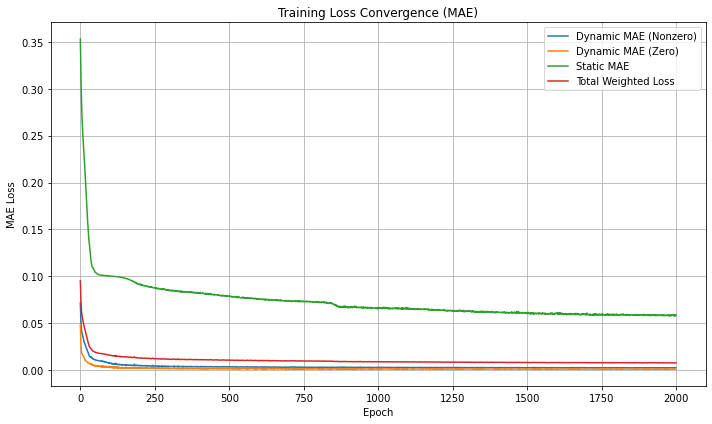

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_logs['loss_dyn_nonzero'], label='Dynamic MAE (Nonzero)')
plt.plot(loss_logs['loss_dyn_zero'], label='Dynamic MAE (Zero)')
plt.plot(loss_logs['loss_stat'], label='Static MAE')
plt.plot(loss_logs['total_loss'], label='Total Weighted Loss')
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.title("Training Loss Convergence (MAE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
    # Convert to numpy and visualize
import matplotlib.pyplot as plt

dynamic_weights = atten_weights[:, 0].cpu().numpy()
static_weights = atten_weights[:, 1].cpu().numpy()

plt.hist(dynamic_weights, bins=50, alpha=0.7, label='Dynamic Weights')
plt.hist(static_weights, bins=50, alpha=0.7, label='Static Weights')
plt.title("Attention Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Count")
plt.legend()
plt.show()

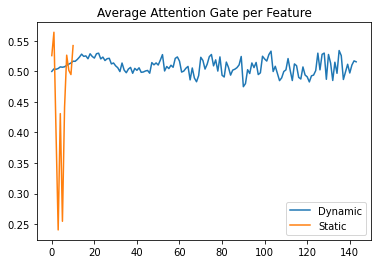

In [31]:
import matplotlib.pyplot as plt

# Mean attention per feature
plt.plot(g_dyn.mean(dim=0).cpu().numpy(), label='Dynamic')
plt.plot(g_stat.mean(dim=0).cpu().numpy(), label='Static')
plt.title("Average Attention Gate per Feature")
plt.legend()
plt.show()

# Saving the Embeddings & MetaData

In [33]:
# Save evaluation metrics
eval_metrics = {
    "final_zero_accuracy": final_zero_acc,
    "final_mae_non_zero": final_mae_non_zero,
    "final_mae_all": final_mae_all,
    "training_zero_accuracies": zero_accuracies,
    "training_non_zero_maes": non_zero_maes,
    "loss_values": loss_values
}

with open(f'{output_folder}/training_metrics_{TYPE_DATA}_{data_set}_{type_graph_conv}.json', 'w') as f:
    json.dump(eval_metrics, f, indent=4)


# Save embeddings in CSV
import pandas as pd
embedding_df = pd.DataFrame(embeddings)

name_file_emb = "node_embeddings_"+TYPE_DATA+"_AutoML-" + str(N_LAYERS) + "_"+ ACTIVATION_OPTION + "_"+ data_set+ "_"+ type_graph_conv +'.csv'

embedding_df.to_csv(f"{output_folder}/"+name_file_emb, index=False)

# Save metadatos (parameters and performance)
metadata = {
    "best_params": best_params,
    "final_loss": loss_values[-1],
    "evaluation_metrics": {
        "zero_accuracy": final_zero_acc,
        "mae_non_zero": final_mae_non_zero
                        },
    "num_features": num_features,
    "loss_func": loss_func,
#     "weight_decay": weightDecay_value,
    "scale_factor": scale_factor
}

with open(f'{output_folder}/model_metadata_{TYPE_DATA}_{data_set}_{type_graph_conv}.json', 'w') as f:
    json.dump(metadata, f, indent=4)

# Save the complete model
torch.save({
    'model_state_dict': best_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'params': best_params
}, f'{output_folder}/best_model_{TYPE_DATA}_{data_set}_{type_graph_conv}.pth')



print("loss_func ", loss_func)
print("Embeddings saved in: "+name_file_emb)
print("Type of graph conv:", type_graph_conv)
print(f"Metadata saved in: model_metadata.json")
print(f"Model saved in: best_model.pth")
str_best_params = "("+str(num_features) + "->" + str(best_params["hidden_dim"]) + "->" + str(best_params["latent_dim"]) + " Ep=" +str(best_params["num_epochs"]) +" | Lr:" + str(best_params["lr"])+")" 
str_best_params

loss_func  MSE
Embeddings saved in: node_embeddings_V2_AutoML-2_relu_real_SAGE.csv
Type of graph conv: SAGE
Metadata saved in: model_metadata.json
Model saved in: best_model.pth


'(155->213->73 Ep=565 | Lr:0.0007523742884534858)'

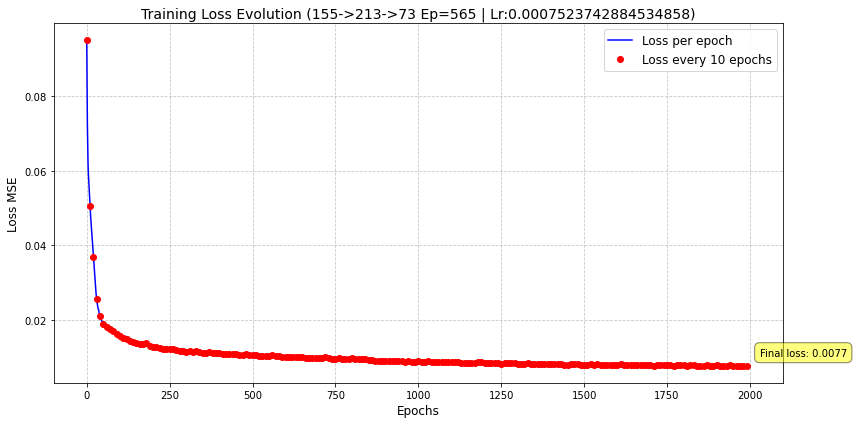

In [35]:
import matplotlib.pyplot as plt

# Create the loss plot with better formatting
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, 'b-', label='Loss per epoch')
plt.plot(epochs[::10], loss_values[::10], 'ro', label='Loss every 10 epochs')  # Pontos cada 10 épocas

plt.title('Training Loss Evolution '+ str_best_params, fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss '+loss_func, fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add annotation with the final loss value
final_loss = loss_values[-1]
plt.annotate(f'Final loss: {final_loss:.4f}', 
             xy=(epochs[-1], loss_values[-1]),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

plt.tight_layout()
plt.show()

# Reading the Embedding

In [36]:
# Load your embeddings CSV

emb_df = pd.read_csv(f"{output_folder}/{name_file_emb}")
emb_df

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,-0.164589,-0.050939,0.232303,0.005247,0.028768,-0.076294,0.203511,0.007434,0.165125,-0.049124,...,0.108021,0.010831,0.062615,0.000136,0.003294,0.037073,0.057030,0.179171,0.137751,0.103424
1,-0.171286,0.002665,0.259270,0.014088,0.005129,-0.056650,0.157054,0.025877,0.069156,-0.065917,...,0.090742,0.036115,-0.015927,0.045377,-0.006458,0.042254,0.015684,0.225684,0.104463,0.066151
2,-0.246977,-0.005869,0.617500,0.089888,0.052078,-0.053587,0.282883,0.050403,0.179627,0.020338,...,0.280179,-0.033254,-0.037775,0.108640,0.027539,0.048112,0.058430,0.407958,0.186186,0.231413
3,-0.143270,-0.034437,0.209308,0.027522,0.004680,-0.068398,0.151741,0.044099,0.131624,-0.034585,...,0.069140,0.051687,0.048343,0.014580,-0.016882,0.032856,0.026339,0.170485,0.078589,0.058299
4,-0.090742,-0.016544,0.040226,-0.031687,0.026024,0.022258,0.015566,0.016476,-0.043189,-0.059450,...,-0.034918,0.073833,-0.002327,-0.005838,-0.054533,-0.017296,-0.045060,0.098789,-0.007341,-0.046846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,-0.083449,0.010650,0.007090,-0.026015,0.020393,-0.015950,0.016834,0.037483,-0.024099,-0.054809,...,-0.059669,0.074880,-0.026428,-0.027996,0.015580,-0.021330,-0.047777,0.089173,-0.021342,-0.067927
14636,-0.108215,-0.002128,-0.010317,-0.010449,0.009722,0.007760,0.023535,0.014696,-0.054650,-0.088211,...,-0.063343,0.065686,-0.016395,-0.006760,-0.009085,0.006650,-0.063609,0.092197,0.001523,-0.078897
14637,-0.096401,0.012970,0.064850,-0.048125,0.031119,0.032063,0.012927,0.010823,-0.023691,-0.047632,...,-0.050740,0.068392,-0.061417,-0.061444,-0.021449,-0.031002,-0.056638,0.090405,-0.049092,-0.043611
14638,-0.110398,0.010419,0.052316,-0.046002,0.043223,0.025643,0.038683,0.015081,-0.023338,-0.068420,...,-0.058789,0.072718,-0.063089,-0.049193,0.007360,-0.023559,-0.039885,0.104310,-0.052450,-0.036518


### TSNE

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import umap.umap_ as umap

print('data_set' ,data_set)

perplexity = 50

# Drop non-numeric columns (e.g., node IDs or labels if present)
numeric_cols = emb_df.select_dtypes(include=[np.number]).columns
emb_df = emb_df[numeric_cols]

# t-SNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
tsne = TSNE(
        n_components=2,
        perplexity=perplexity,             # más alto para datos grandes
        n_iter=1500,               # más iteraciones
        learning_rate=300,         # o prueba n_samples/12 = 89240/12 ≈ 7437
        method='barnes_hut',       # eficiente para 2D
        random_state=42,
        verbose=1
    )
tsne_result = tsne.fit_transform(emb_df)

data_set real
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 14640 samples in 0.001s...
[t-SNE] Computed neighbors for 14640 samples in 3.573s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14640
[t-SNE] Computed conditional probabilities for sample 2000 / 14640
[t-SNE] Computed conditional probabilities for sample 3000 / 14640
[t-SNE] Computed conditional probabilities for sample 4000 / 14640
[t-SNE] Computed conditional probabilities for sample 5000 / 14640
[t-SNE] Computed conditional probabilities for sample 6000 / 14640
[t-SNE] Computed conditional probabilities for sample 7000 / 14640
[t-SNE] Computed conditional probabilities for sample 8000 / 14640
[t-SNE] Computed conditional probabilities for sample 9000 / 14640
[t-SNE] Computed conditional probabilities for sample 10000 / 14640
[t-SNE] Computed conditional probabilities for sample 11000 / 14640
[t-SNE] Computed conditional probabilities for sample 12000 / 14640
[t-SNE] Computed conditional probab

In [40]:


tsne_df = pd.DataFrame(tsne_result)
tsne_df.to_csv(f"{output_folder}/tsne_output_{TYPE_DATA}_{suffix}.csv", index=False)

### Coloring tsne output using original cluster IDs

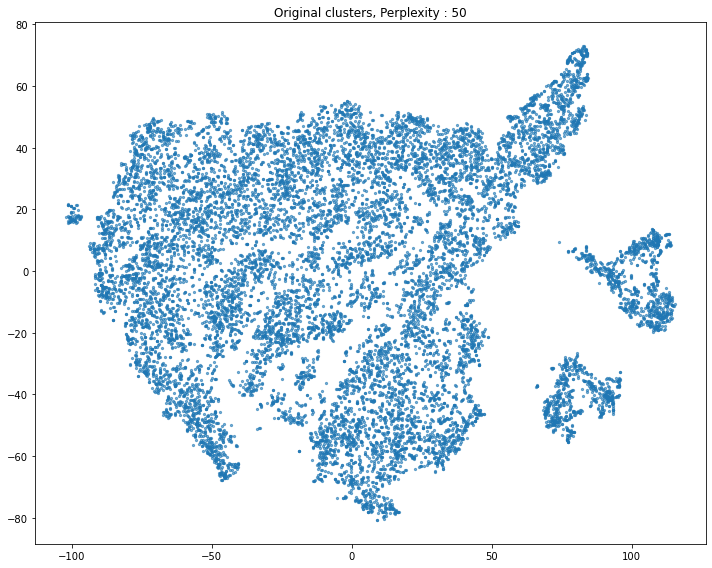

In [41]:
import matplotlib.colors as mcolors

# # Visualization
plt.figure(figsize=(10, 8))
cmap = mcolors.ListedColormap(plt.cm.tab20.colors[8:])
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], 
                      alpha=0.6, s = 5)
# plt.colorbar(scatter, label='Cluster ID')
plt.title(f'Original clusters, Perplexity : {perplexity}')
plt.tight_layout()
plt.savefig(f'{output_folder}/tsne_original_Ids_{TYPE_DATA}_{data_set}_{type_graph_conv}.png', dpi=300) 
plt.show()

## Apply Kmeans on Embeddings

In [42]:
from sklearn.cluster import KMeans

n_clusters = 12

# train K-means 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(emb_df)

In [43]:
# add Kmeans cluster IDs
df_nodes['clusterID_kmeans_'+TYPE_DATA] = clusters


### Coloring tsne output using Kmeans cluster IDs

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], 
                     c=df_nodes['clusterID_kmeans_'+TYPE_DATA], cmap=cmap, alpha=0.6, s = 5)

plt.title(f'K-means clusters:{n_clusters}, perplexit: {perplexity}')
plt.tight_layout()
plt.savefig(f'{output_folder}/tsne_kmeans_Ids_{TYPE_DATA}_{data_set}_{type_graph_conv}.png', dpi=300) 
plt.show()

In [ ]:
# Seleccionar las columnas
columns_to_save = ['Nodo', f'clusterID_kmeans_{TYPE_DATA}']
df_selected = df_nodes[columns_to_save]

# Crear nombre de archivo
filename = f'to_dissim_clusterID_kmeans_{TYPE_DATA}_{data_set}_{type_graph_conv}.csv'

# Guardar como CSV
df_selected.to_csv(f"{output_folder}/{filename}", index=False)

print(f'Archivo guardado como: {filename}')


## Locating clusters using kmeans cluster_ids

#### normalize dynamic and static on same scale

In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist, pdist
from itertools import combinations
from fastdtw import fastdtw
from multiprocessing import Pool, cpu_count

# # Data type configuration
data_type = "dynamic"   # "or dynamic" static # Choose dynamic for cross clustering


# Create filename
filepath = f'{output_folder}/{filename}'
print(filepath)

# Open file with columns [Nodo,clusterID_kmeans_] 
df_clusters = pd.read_csv(filepath)
name_column = 'clusterID_kmeans_'+TYPE_DATA

if data_type == "static":
    df_features_clusters = pd.concat([static_dt_norm, df_clusters], axis = 1)
else:
    df_features_clusters = pd.concat([dynamic_dt_norm, df_clusters], axis = 1)


# Removing 'Nodo' column
df_features_clusters = df_features_clusters.drop(columns=['Nodo'])

# Group the DataFrame by 'clusterID' and convert each group to a list
listas_por_cluster = [group.drop(name_column, axis=1).values.tolist() for _, group in df_features_clusters.groupby(name_column)]


# Calculation of distances

In [ ]:

# ===================
# subsampling at 10%
# # ===================

import random
sub_listas_por_cluster = []
max_samples = 200  # set your maximum threshold here

for lista in listas_por_cluster:
    n = len(lista)
    muestra_size = min(max_samples, max(1, int(0.05 * n)))  # limit the sample size
    muestra = random.sample(lista, muestra_size) if n >= muestra_size else lista.copy()
    sub_listas_por_cluster.append(muestra)

for idx, sublista in enumerate(sub_listas_por_cluster):
    print(f"Cluster {idx}: {len(sublista)} samples")

# ===================
# DISTANCE FUNCTIONS
# ===================
def average_intra_cluster_distance(X_cluster, data_type='static'):
    n = len(X_cluster)
    if n <= 1:
        return 0.0
    if data_type == 'static':
        return np.mean(pdist(X_cluster, 'euclidean'))
    elif data_type == 'dynamic':
        distances = []
        for i in range(n):
            for j in range(i + 1, n):
                dist, _ = fastdtw(X_cluster[i], X_cluster[j])
                distances.append(dist)
        return np.mean(distances)
    else:
        raise ValueError("data_type must be either 'static' or 'dynamic'")

def minimum_inter_cluster_distance(X_cluster_i, X_cluster_j, data_type='static'):
    if len(X_cluster_i) == 0 or len(X_cluster_j) == 0:
        return np.inf
    if data_type == 'static':
        dist_matrix = cdist(X_cluster_i, X_cluster_j, 'euclidean')
    elif data_type == 'dynamic':
        dist_matrix = np.zeros((len(X_cluster_i), len(X_cluster_j)))
        for i in range(len(X_cluster_i)):
            for j in range(len(X_cluster_j)):
                dist, _ = fastdtw(X_cluster_i[i], X_cluster_j[j])
                dist_matrix[i, j] = dist
    else:
        raise ValueError("data_type must be either 'static' or 'dynamic'")
    return np.min(dist_matrix)

def compute_cluster_dissimilarity2(a_i, a_j, b_ij):
    denom1 = np.maximum(a_i, b_ij)
    term1 = np.divide(b_ij - a_i, denom1, out=np.zeros_like(np.array([b_ij])), where=(denom1 != 0))
    denom2 = np.maximum(a_j, b_ij)
    term2 = np.divide(b_ij - a_j, denom2, out=np.zeros_like(np.array([b_ij])), where=(denom2 != 0))
    return 0.5 * (term1 + term2)

def compute_pair_dissimilarity(args):
    i, j, clusters, data_type = args
    a_i = average_intra_cluster_distance(clusters[i], data_type)
    a_j = average_intra_cluster_distance(clusters[j], data_type)
    b_ij = minimum_inter_cluster_distance(clusters[i], clusters[j], data_type)
    S_ij = compute_cluster_dissimilarity2(a_i, a_j, b_ij)
    return (i, j, S_ij)

def compute_all_cluster_dissimilarities(clusters, data_type='static'):
    n = len(clusters)
    S = np.zeros((n, n))

    args_list = [(i, j, clusters, data_type) for i, j in combinations(range(n), 2)]

    with Pool(processes=cpu_count()) as pool:
        results = pool.map(compute_pair_dissimilarity, args_list)

    for i, j, S_ij in results:
        S[i, j] = S[j, i] = S_ij

    print("Matriz de disimilitudes:\n", S)
    return S

# ===================
# Execution
# ===================

time_start = datetime.now()
print('time_start', time_start.strftime("%H:%M:%S"), 'para', data_type)

if data_type == "static":
    D = compute_all_cluster_dissimilarities(listas_por_cluster, data_type=data_type)
else: # cross clustering option
    D = compute_all_cluster_dissimilarities(sub_listas_por_cluster, data_type=data_type)
    
time_end = datetime.now()
print(time_start.strftime("%H:%M:%S"), '-', time_end.strftime("%H:%M:%S"))

elapsed_time = (time_end - time_start).total_seconds()
print('Elapsed time:', str(elapsed_time), 'seconds')


In [ ]:
df = pd.DataFrame(D)
df.to_csv(f'{output_folder}/cluster_dissimilarities_matrix_{TYPE_DATA}_{data_set}_{data_type}_{type_graph_conv}.csv', index=False)

print(f'Final result: cluster_dissimilarities_matrix_{TYPE_DATA}_{data_set}_v1_clusterID_D_in_{data_type}_{type_graph_conv}.csv')